# Load a pretrained model

In [1]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.
/home/shuvendu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

/home/shuvendu/anaconda3/lib/python3.6/site-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


# Load an image

In [2]:
img_path = '/media/shuvendu/Projects/Datasets/Cat_and_Dog_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
print(type(img))


<class 'PIL.Image.Image'>


In [3]:
img_tensor = image.img_to_array(img)
print(type(img_tensor))
print(img_tensor.shape)

<class 'numpy.ndarray'>
(150, 150, 3)


In [4]:
# add one more dimension for batchsize
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


# Display the image

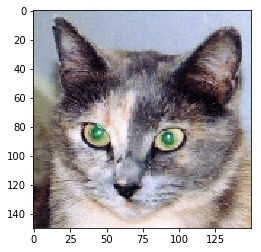

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])

# Instantiating a model from an input tensor and a list of output tensors

In [6]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Running the model in predict mode

In [7]:
activations = activation_model.predict(img_tensor)

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


# Visualizing specific channel

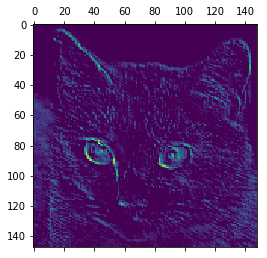

In [9]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

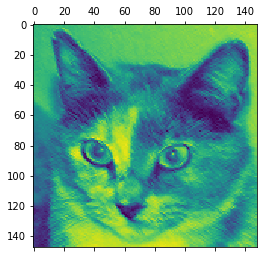

In [10]:
plt.matshow(first_layer_activation[0, :, :, 27], cmap='viridis')

# Visualizing convnet filters

In [11]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',include_top=False)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [13]:
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:, filter_index])

To implement gradient descent, you’ll need the gradient of this loss with respect to
the model’s input. To do this, you’ll use the gradients function packaged with the
backend module of Keras.

## Obtaining the gradient of the loss with regard to the input

In [14]:
grads = K.gradients(loss, model.input)[0]

A non-obvious trick to use to help the gradient-descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (the square root of the average
of the square of the values in the tensor). This ensures that the magnitude of the
updates done to the input image is always within the same range.

## Gradient-normalization trick

In [15]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

## Fetching numpy output values given Numpy input

In [16]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [17]:
loss_value

0.0

In [18]:
grads_value.shape

(1, 150, 150, 3)

## Loss maximization via stochastic gradient descent

In [19]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

step = 1
for i in range(40):
    loss_value, grad_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

## Utility function to convert a tensor into a valid image

In [20]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to generate filter visualization

In [21]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

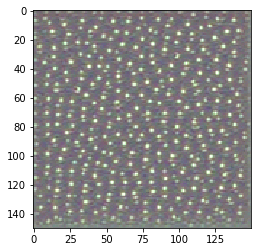

In [22]:
plt.imshow(generate_pattern('block3_conv1', 0))

# Visualize all layers

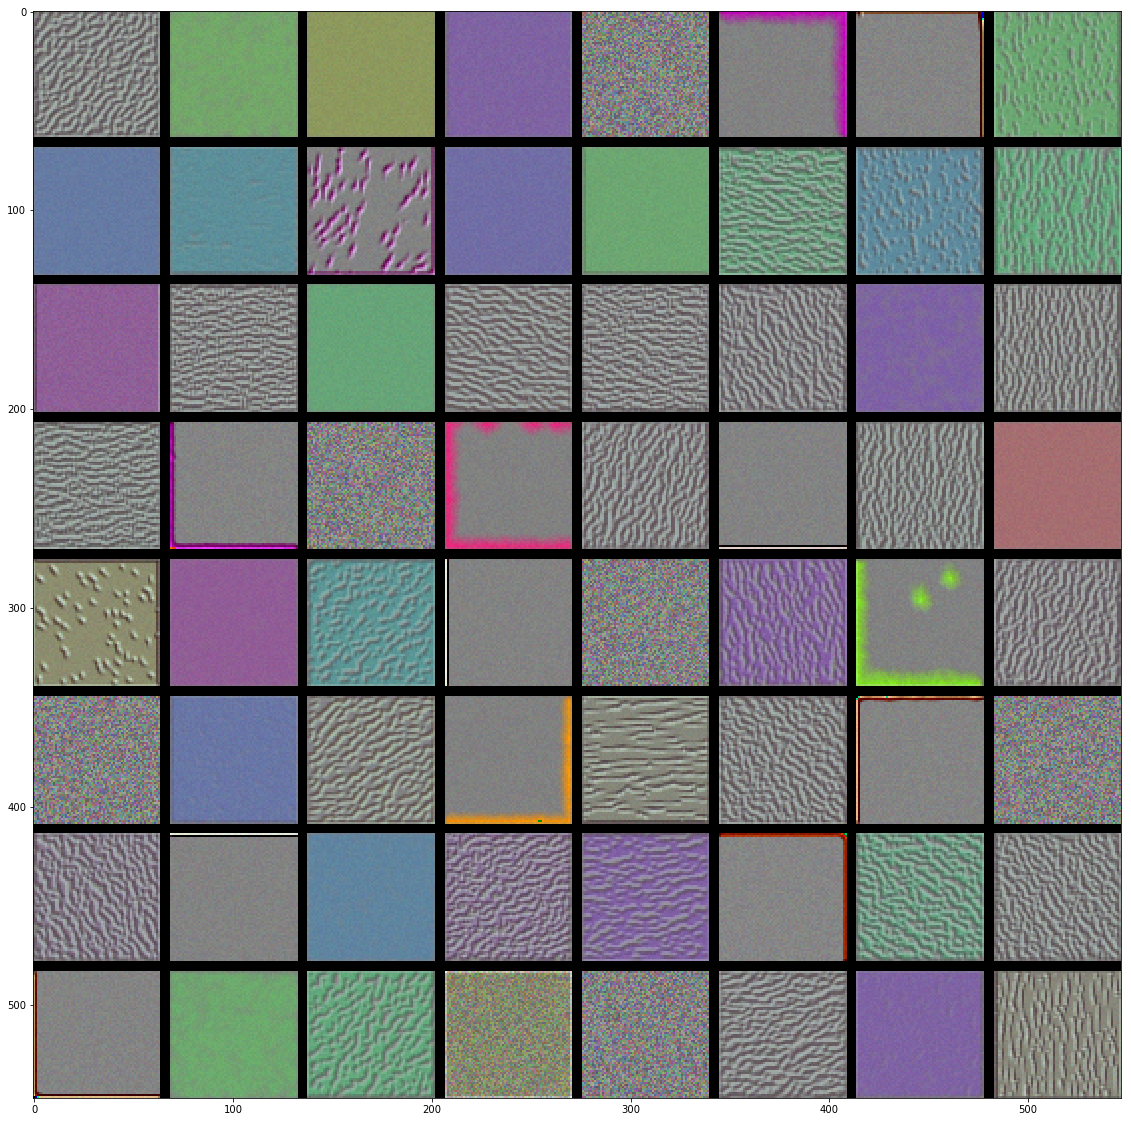

In [23]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
    
plt.figure(figsize=(20, 20))
plt.imshow(results)

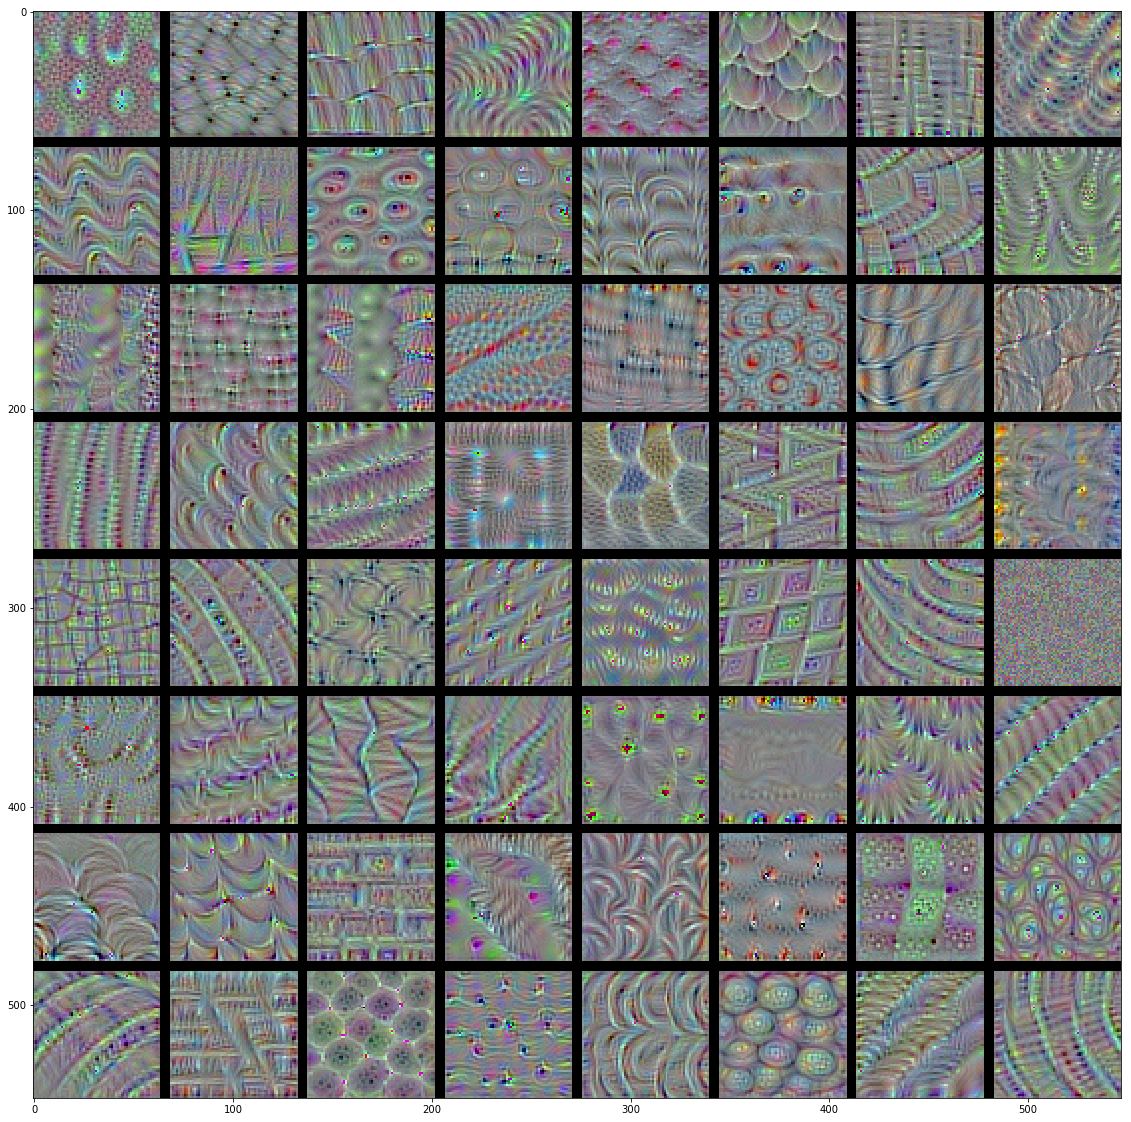

In [24]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
    
plt.figure(figsize=(20, 20))
plt.imshow(results)